The analysis below is based on the procedure described in the texts below.
    
* https://www.matthewjockers.net/2014/06/05/a-novel-method-for-detecting-plot/
* https://www.matthewjockers.net/2015/02/02/syuzhet/

In [12]:
import os
import re
from nltk.tokenize import sent_tokenize
import scipy.signal as sp
from tdmh import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
ana = SentimentIntensityAnalyzer()
import sklearn
from sklearn.preprocessing import minmax_scale
import pandas as pd
import math
from math import ceil
#import stanza
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma')

Firstly, we specify the text that needs to be analysed. 

In [2]:
text =  'syuzhet_R/data/PictureOfDorianGray.txt'

We obtain the full text of the novel as one long string. 

In [3]:
def get_text_as_string(path):
    with open(path , encoding = 'utf-8') as text_file:
        full_text = text_file.read()
        full_text = re.sub( '\s+' , ' ' , full_text)
        return full_text
    
full_text = get_text_as_string( text )
print(len(full_text))

295088


If the same text is read using the R Syuzhet package in R, this strangely results in a string of 299045 characters. The package appears to use a slightly different method for converting the text file into a string. 

In [4]:
def get_sentences(full_text):
    full_text = re.sub( '\n+' , '' , full_text )
    sentences = sent_tokenize(full_text)
    return sentences

sentences = get_sentences(full_text)
print( len(sentences) )
print( sentences[2] )

4256
The studio was filled with the rich odor of roses, and when the light summer wind stirred amidst the trees of the garden there came through the open door the heavy scent of the lilac, or the more delicate perfume of the pink-flowering thorn.


The method for recognising sentences appears to be similar. The R package detects 4251 sentences. The code above results in 4256 sentences, a negligible difference. 

# Visualisation of sentiments

As a next step, we try to assign sentiment scores to each of these sentences. We can do this using Vader. 

In [5]:
def get_sentiment_vader( sentences ):
    all_scores = []
    if len(sentences)>0:
        for s in sentences:
            scores = ana.polarity_scores(s)
            all_scores.append( scores['compound'] )
    return all_scores

scores = get_sentiment_vader(sentences)


As we can see, when we plot the scores that are generated against the 'bovel time', he scores that are generated fluctuate very strongly. 

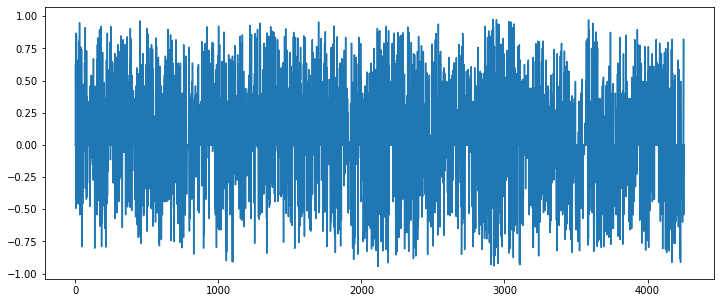

In [6]:
novel_time = range( 0, len(scores))
plt.figure( figsize=(12,5) )
sns.lineplot( x = novel_time , y = scores )
plt.show()

We can address this issue by calculating "rolling averages". In the function below, the window size is set at 10% of the total number of scores. 

In [7]:
def rolling_average(scores):
    all_averages = []
    window_size = math.ceil( 0.10 * len(scores) )
    start_index = 0
    end_index = window_size
    
    subset = scores[start_index:end_index]
    avg = sum(subset)/len(subset)
    
    all_averages.append(avg)
    
    while end_index < len(scores):
        
        start_index += 1
        end_index = (start_index + window_size)
        if end_index > len(scores):
            end_index = len(scores)
                        
        subset = scores[start_index:end_index]
        
        avg = sum(subset)/len(subset)
        
        all_averages.append(avg)
    return all_averages
        
ra = rolling_average(scores)

Such rolling averages can also be created using `rolling().mean()` in Pandas, but when we define the method ourselves, this makes the process more transparent. 

To make the plots for different novels more comparable, we also 'decimate' the rolling averages. This essentially means that we select observations at regular intervals and we discard all the other observations. There is inevitably some loss of information when we do this, but the result still enables us to trace when the scores rise and when they fall. The function below makes use of the `decimate()` function from `sklearn.signal`. It returns a list of 100 values.

In [26]:
def decimate_scores(scores):
    x = math.floor(len(scores)/100)
    scores_dec = sp.decimate(scores,x)
    scores = scores_dec.tolist()
    return scores[:100]

ra_dec = decimate_scores(ra)
print( len(ra_dec) )

100


The plot now looks as follows.

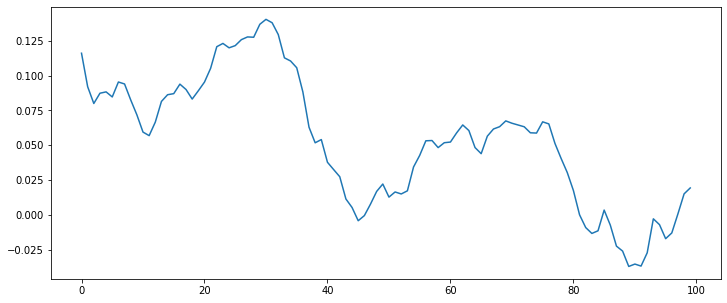

In [19]:
scores = ra_dec

novel_time = range( 0, len(scores))
plt.figure( figsize=(12,5) )
sns.lineplot( x = novel_time , y = scores )
plt.show()

This plot looks more or less the same as the plot created by Jockers.

<img src="https://www.matthewjockers.net/wp-content/uploads/2014/06/dorian1.png" />

For comparison, we can place the scores generated using Vader next to the scores created using the Syuzhet lexicon. The CSV file 'sjuzhet_sentiments.csv' is a list of sentiments scores, created using the R package.  

In [29]:
dfr = pd.read_csv('syuzhet_R/data/sjuzhet_sentiments.csv') 
dfr['x'] = dfr['x'].astype(float)
scores = dfr['x'].tolist()

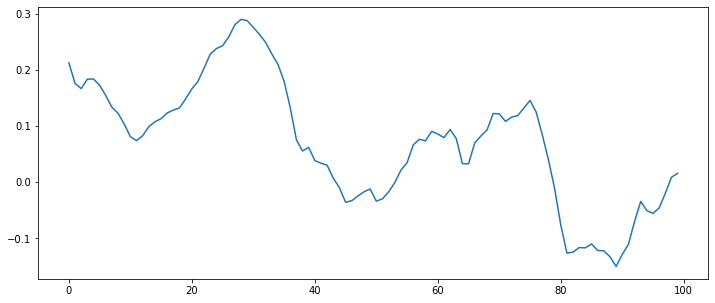

In [30]:
ra = rolling_average(scores)
scores = decimate_scores(ra)

novel_time = range( 0, len(scores))
plt.figure( figsize=(12,5) )
sns.lineplot( x = novel_time , y = scores )
plt.show()

In [ ]:
max_score = max(scores)
print(max_score)

for i,s in enumerate(scores):
    if s == max_score:
        print( sentences[i] )
    

## Plotting

In [ ]:
novel_time = range( 0, len(scores))
plt.figure( figsize=(12,5) )
sns.lineplot( x = novel_time , y = scores )
plt.show()

In [ ]:
print(len(novel_time))

In [ ]:
#df_temperature['SMA_10'] = df_temperature.average_temperature.rolling(10, min_periods=1).mean()


## Next decimate the data

We need to make sure that the total number of observations is 100. 

In [ ]:
## R data

In [ ]:
dfr = pd.read_csv('syuzhet_R/data/sjuzhet_sentiments.csv') 

window_size = math.ceil( 0.10 * dfr['x'].count() )
print(dfr['x'].count() )
print(window_size)

dfr['x']
ra2 = dfr['x'].rolling(window_size).mean()
print(ra)
ra2 = ra2.tolist()
print(ra2)




In [ ]:
scores_plot = ra
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
#ax.set_xticks(novel_time)
plt.show()

In [ ]:
scores_plot = ra_dec
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
#ax.set_xticks(novel_time)
plt.show()

In [ ]:
scores_plot = moving_averages
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
#ax.set_xticks(novel_time)
plt.show()

In [ ]:
print(moving_averages)

In [ ]:
print (len(moving_averages))
x = ceil(len(moving_averages)/100)
ra_dec = decimate(moving_averages,x)
#print(ra_dec)
new_list = []

for i in range(0,len(moving_averages)+1):
    if i % x == 0:
        new_list.append(moving_averages[i])
        
print(len(new_list))
print(new_list)

In [ ]:
scores_plot = ra_dec
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
#ax.set_xticks(novel_time)
plt.show()